<a href="https://colab.research.google.com/github/Aishwary099/DNA-mutation-data-analysis/blob/main/Retinal_Image_Analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4
All done


In [2]:
Path_data = '/content/drive/MyDrive/dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/content/drive/MyDrive/dataset/Healthy')
Mild = os.listdir('/content/drive/MyDrive/dataset/Mild DR')
Moderate = os.listdir('/content/drive/MyDrive/dataset/Moderate DR')
Proliferate = os.listdir('/content/drive/MyDrive/dataset/Proliferate DR')
Severe = os.listdir('/content/drive/MyDrive/dataset/Severe DR')

In [3]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [4]:
# Get Paths

Path_data = '/content/drive/MyDrive/dataset'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

Paths   Labels
0  /content/drive/MyDrive/dataset/Healthy/Healthy...  Healthy
1  /content/drive/MyDrive/dataset/Healthy/Healthy...  Healthy
2  /content/drive/MyDrive/dataset/Healthy/Healthy...  Healthy
3  /content/drive/MyDrive/dataset/Healthy/Healthy...  Healthy
4  /content/drive/MyDrive/dataset/Healthy/Healthy...  Healthy

In [5]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           805
Moderate DR       723
Mild DR           291
Proliferate DR    230
Severe DR         151
Name: count, dtype: int64

In [6]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


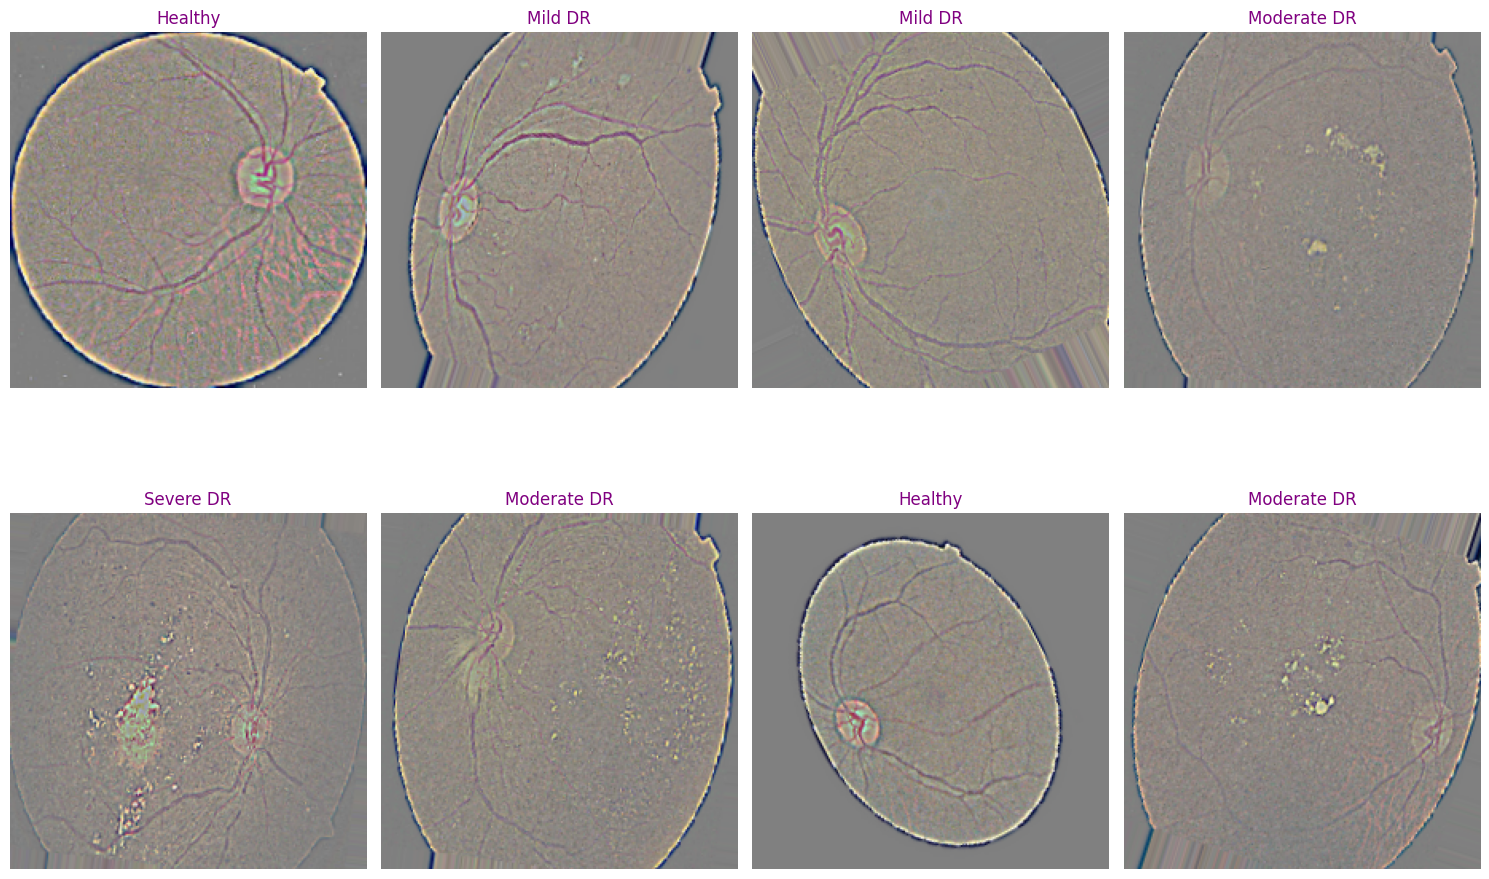

In [7]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))

In [10]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,735,348 (44.77 MB)

 Trainable params: 11,648,045 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

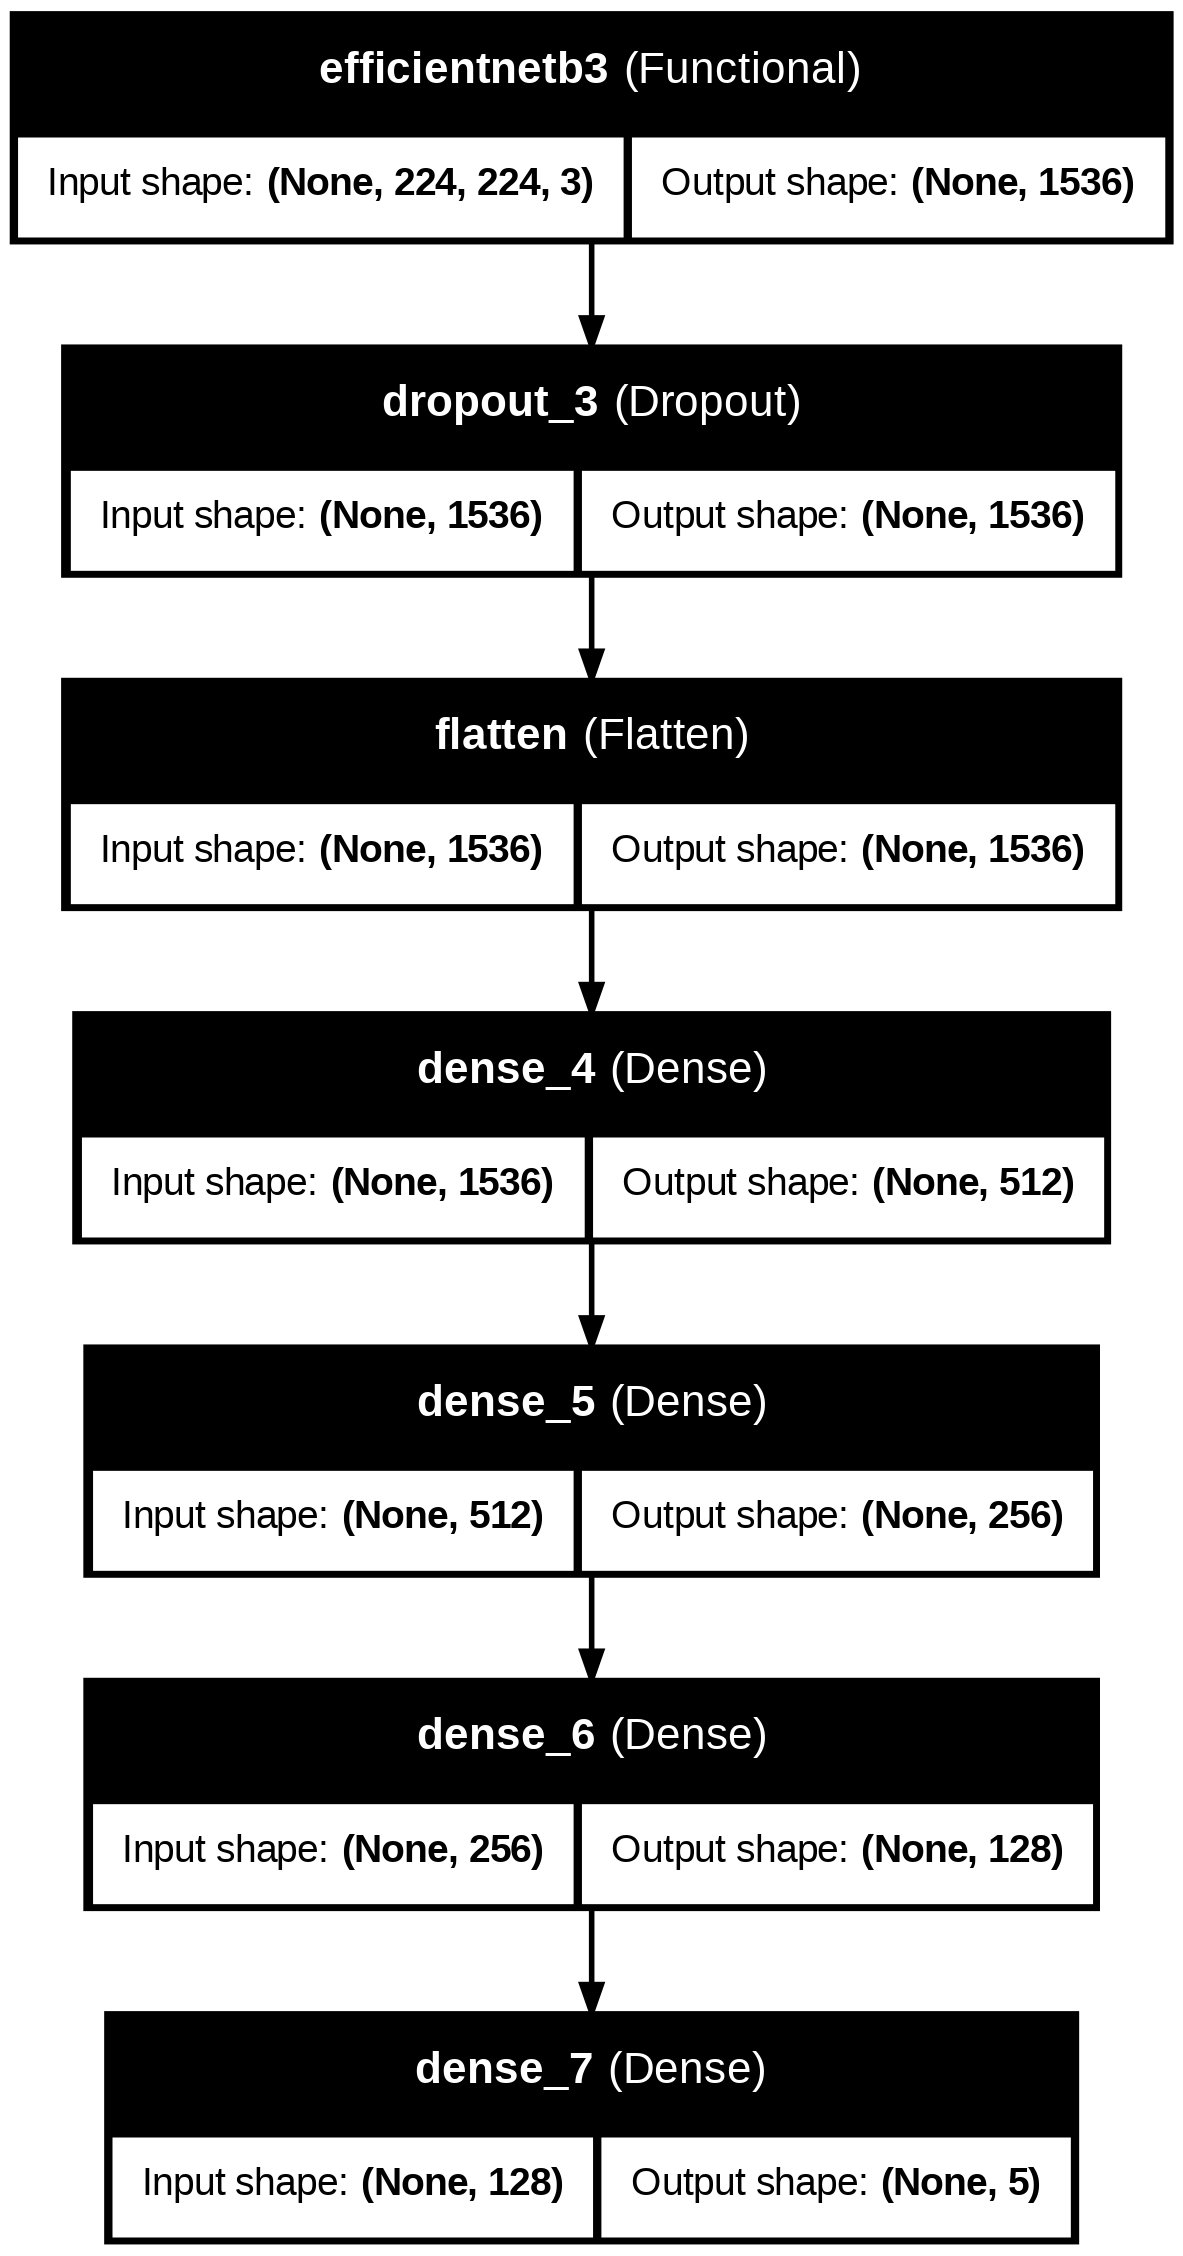

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [13]:
epochs = 40
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 1103s 9s/step - acc: 0.4127 - loss: 2.0890 - val_acc: 0.4109 - val_loss: 1.5725
Epoch 2/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 395ms/step - acc: 0.5655 - loss: 1.2962 - val_acc: 0.6036 - val_loss: 1.1550
Epoch 3/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 401ms/step - acc: 0.5959 - loss: 1.1193 - val_acc: 0.6545 - val_loss: 0.9121
Epoch 4/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 401ms/step - acc: 0.5953 - loss: 1.0670 - val_acc: 0.6800 - val_loss: 0.8449
Epoch 5/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 399ms/step - acc: 0.6213 - loss: 0.9719 - val_acc: 0.6982 - val_loss: 0.7770
Epoch 6/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 400ms/step - acc: 0.6662 - loss: 0.9021 - val_acc: 0.7164 - val_loss: 0.7945
Epoch 7/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 402ms/step - acc: 0.6570 - loss: 0.8712 - val_acc: 0.7309 - val_loss: 0.7331
Epoch 8/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 46s 416ms/step - acc: 0.6713 - loss: 0.8355 - val_acc: 0.7127 - val_loss: 0.7566
Epoch 9/40
110/110 ━━━━━━━━━━━━━━

In [14]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

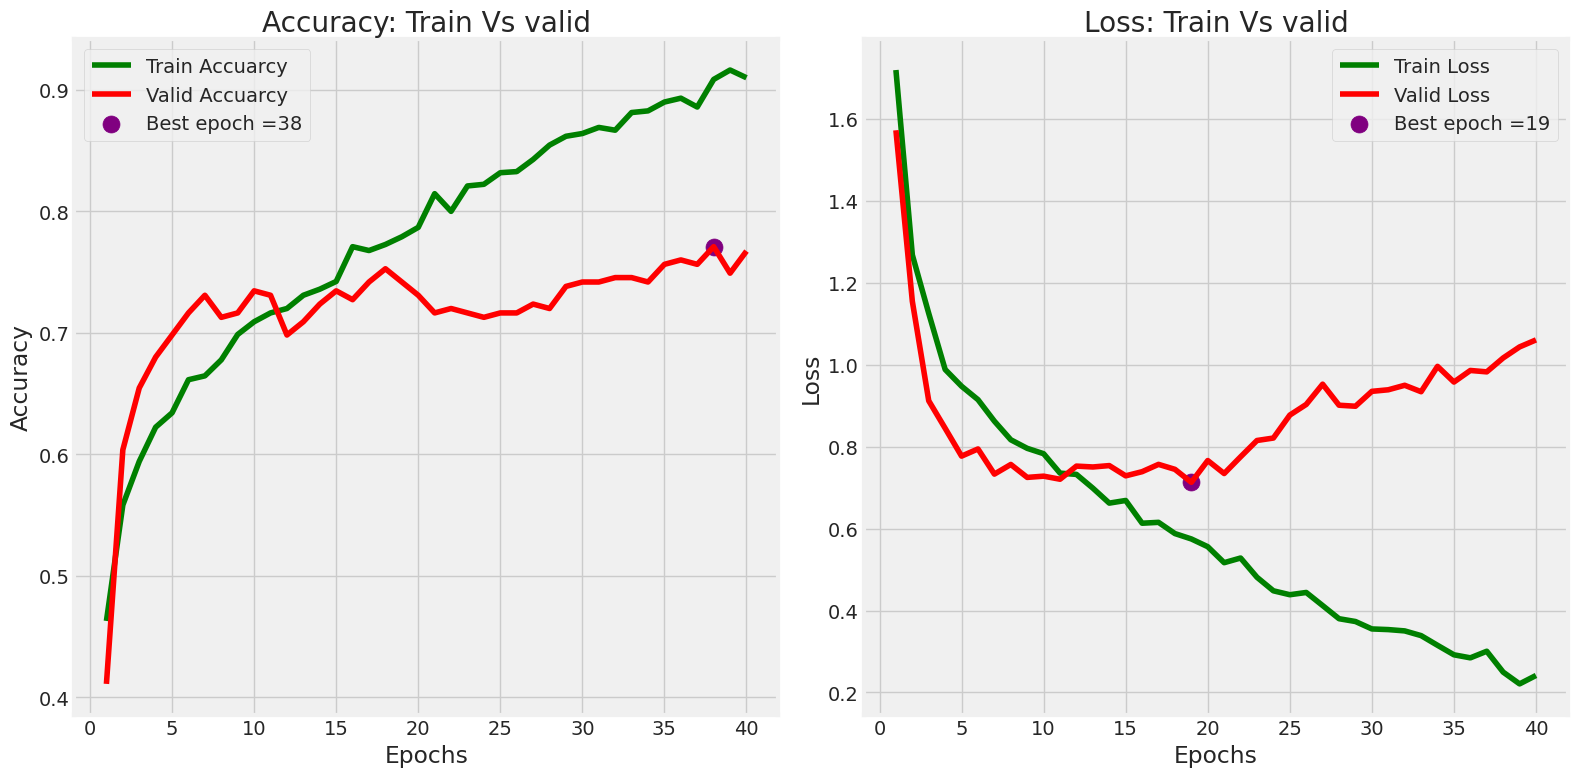

In [15]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - acc: 0.9736 - loss: 0.0828
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - acc: 0.7891 - loss: 0.9832
14/14 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - acc: 0.7659 - loss: 0.9190
Train Scores : 
    accuracy: 0.9700000286102295 
      Loss:  0.09005431085824966 
________________________
Valid Scores : 
    accuracy: 0.7672727108001709 
      Loss:  1.0607317686080933 
________________________
Test Scores : 
    accuracy: 0.774545431137085 
      Loss:  0.9211629033088684 
________________________


In [18]:
predictions = model.predict(Test) # Replace predict_generator with predict
y_pred = np.argmax(predictions, axis=1)

# Check
print(predictions)
print(y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 789ms/step
[[8.20981622e-01 3.88165354e-05 1.78941593e-01 3.77610268e-05
  2.03844010e-07]
 [9.99299049e-01 6.56356453e-04 2.85555707e-05 1.59350930e-05
  2.12695745e-08]
 [2.91420758e-01 2.67513901e-01 4.37438786e-01 2.61326972e-03
  1.01318816e-03]
 ...
 [3.85706662e-03 1.41824353e-02 1.43531889e-01 8.25606585e-01
  1.28220590e-02]
 [9.99984980e-01 1.48931595e-05 1.16070815e-07 4.91450522e-13
  6.52956422e-13]
 [3.07528884e-04 3.13156960e-03 1.62341431e-01 8.19162190e-01
  1.50572741e-02]]
[0 0 2 3 2 2 3 2 2 2 1 0 0 1 2 4 2 4 1 0 1 0 0 2 2 2 2 2 2 2 2 0 1 2 0 1 2
 2 2 1 1 1 2 1 2 2 0 2 0 2 2 2 2 0 2 1 1 1 2 1 0 2 2 2 1 4 3 1 0 2 0 4 0 0
 2 2 0 2 0 0 2 2 1 2 0 4 0 2 2 3 1 3 2 2 1 2 0 2 2 1 0 2 0 3 0 0 0 0 0 4 2
 1 4 0 0 2 0 0 2 2 0 2 0 3 2 2 2 0 0 4 0 1 2 2 2 3 4 0 1 0 0 0 0 1 0 0 2 0
 0 4 0 0 1 0 2 0 1 2 2 4 3 2 0 2 2 1 0 2 2 0 2 0 2 1 0 2 0 1 1 2 0 0 1 4 1
 0 2 1 2 4 4 0 0 0 0 0 2 2 2 2 2 3 0 2 0 0 2 2 2 0 2 0 2 2 0 0 2 0 4 0 2 2
 2 1 2 2 0 2 0 0 2 0 0

In [19]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[92,  0,  0,  0,  0],
       [ 2, 28, 11,  0,  0],
       [ 3,  9, 78,  5,  5],
       [ 0,  4,  6,  8,  5],
       [ 0,  1, 11,  0,  7]])

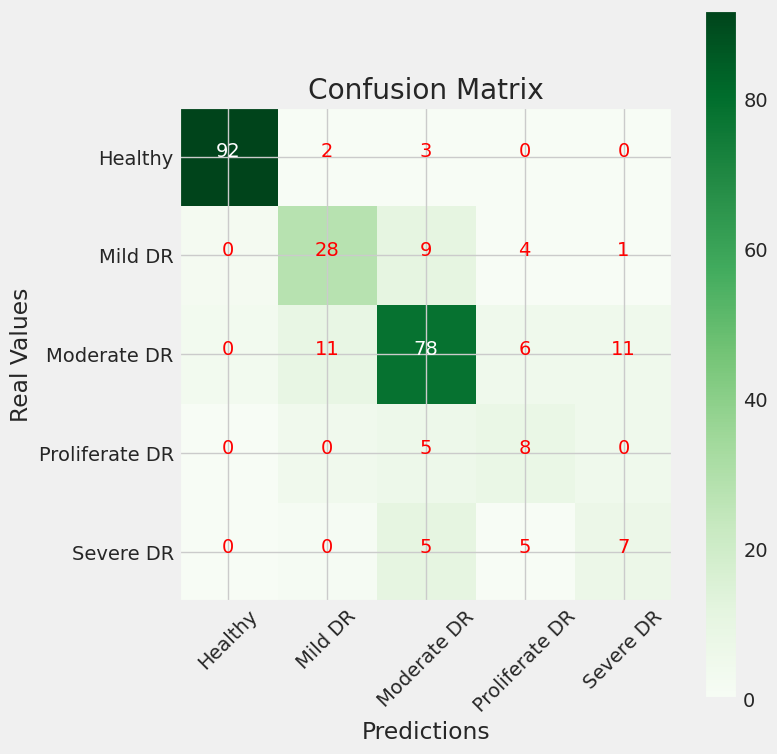

In [20]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [21]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

                precision    recall  f1-score   support

       Healthy       0.95      1.00      0.97        92
       Mild DR       0.67      0.68      0.67        41
   Moderate DR       0.74      0.78      0.76       100
Proliferate DR       0.62      0.35      0.44        23
     Severe DR       0.41      0.37      0.39        19

      accuracy                           0.77       275
     macro avg       0.68      0.64      0.65       275
  weighted avg       0.76      0.77      0.77       275



In [22]:
# Get predictions for the test dataset
test_steps = Test.samples // Test.batch_size
predictions = model.predict(Test, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = Test.classes
class_labels = list(Test.class_indices.keys())


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step


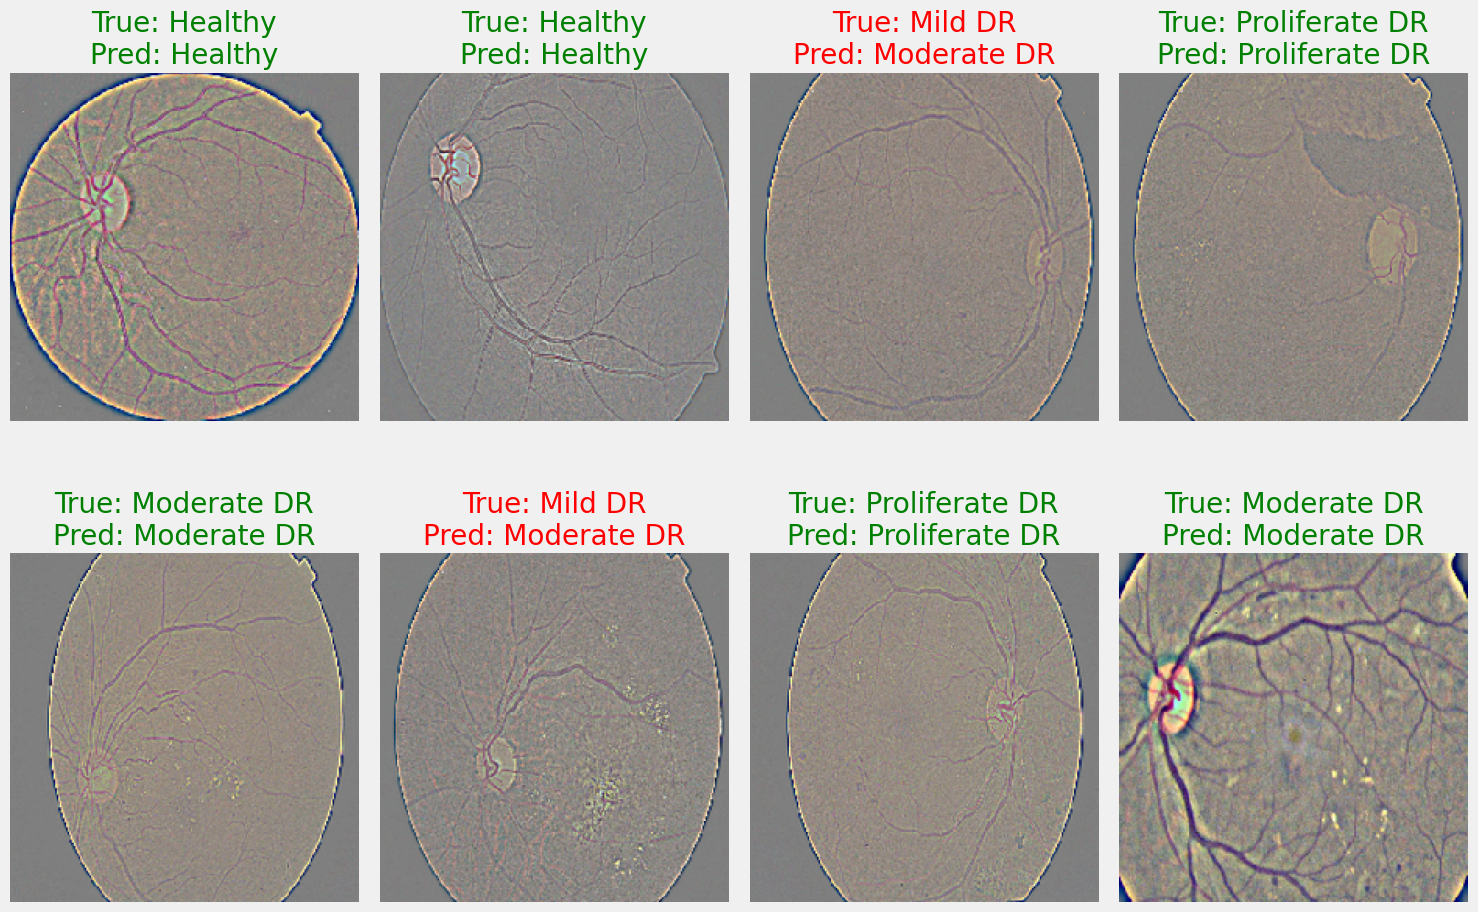

In [23]:
# Visualize a few test images with their predictions
import matplotlib.pyplot as plt

# Get a batch of test images and labels
test_images, test_labels = next(Test)

# Plot the images with their predicted and true labels
plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(3, 4, i + 1)
    img = test_images[i] / 255.0
    plt.imshow(img)

    # Get the true and predicted labels
    true_label_idx = np.argmax(test_labels[i])
    true_label = class_labels[true_label_idx]
    predicted_label_idx = np.argmax(predictions[i])
    predicted_label = class_labels[predicted_label_idx]

    # Set the title with colors indicating correctness
    color = "green" if true_label == predicted_label else "red"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
model.save('effB3 CNN DR.h5')

In [25]:
# Save the model in the recommended .keras format
model.save('effB3_CNN_DR.keras')


In [26]:
from google.colab import files
files.download('effB3_CNN_DR.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>